# Dataset

In [3]:
# Read dataset

import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
test_labels_df = pd.read_csv('data/test_labels.csv')

# Processing

In [4]:
# Clean up text

import re

def strip_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

train_df['cleaned_comment'] = train_df['comment_text'].apply(strip_text)

In [5]:
# Tokenization

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_df['tokenized_comment'] = train_df['cleaned_comment'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pache\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Lemmatization

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

train_df['lemmatized_comment'] = train_df['tokenized_comment'].apply(lemmatize_words)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pache\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['cleaned_comment'])

# Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train['toxic'])

LogisticRegression(max_iter=1000)

# Evaluation

In [10]:
from sklearn.metrics import balanced_accuracy_score

y_pred = clf.predict(X_val)
score = balanced_accuracy_score(y_val['toxic'], y_pred)
print(f'Balanced Accuracy Score: {score}')

Balanced Accuracy Score: 0.8066230212285078


# Word Importances (Evaluation)

In [11]:
feature_names = vectorizer.get_feature_names_out()
sorted_items = sorted(zip(clf.coef_[0], feature_names))
print("Most important words for toxicity classification:")
for coef, word in sorted_items[-10:]:
    print(f"{word}: {coef}")

Most important words for toxic classification:
suck: 7.769362188064458
crap: 8.012078185027285
asshole: 8.426268397571025
bullshit: 8.48006960993103
ass: 8.587727114813456
stupid: 10.940946622399819
idiot: 10.953909945532475
shit: 11.020533861657896
fucking: 12.974601733286594
fuck: 15.155138257443555


# Topic Models

In [26]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_lda = vectorizer.fit_transform(train_df['cleaned_comment'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_lda)

topic_distribution = lda.transform(X_train_lda)

train_df['dominant_topic'] = topic_distribution.argmax(axis=1)

toxicity_per_topic = train_df.groupby('dominant_topic')['toxic'].mean()

for topic_idx, toxicity_rate in toxicity_per_topic.items():
    print(f"Topic {topic_idx}: Toxicity Rate = {toxicity_rate * 100:.2f}%")

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)


Topic 0: Toxicity Rate = 24.22%
Topic 1: Toxicity Rate = 3.86%
Topic 2: Toxicity Rate = 3.12%
Topic 3: Toxicity Rate = 2.15%
Topic 4: Toxicity Rate = 8.42%
Topic 0:
page wikipedia talk dont edit like fuck just edits im
Topic 1:
article think just people sources dont like source does section
Topic 2:
article page deletion wikipedia deleted image use articles tag copyright
Topic 3:
page talk article thanks help wikipedia like know just hi
Topic 4:
people english new gay world states like american shit school


# Relevant Figures

### Word Importance

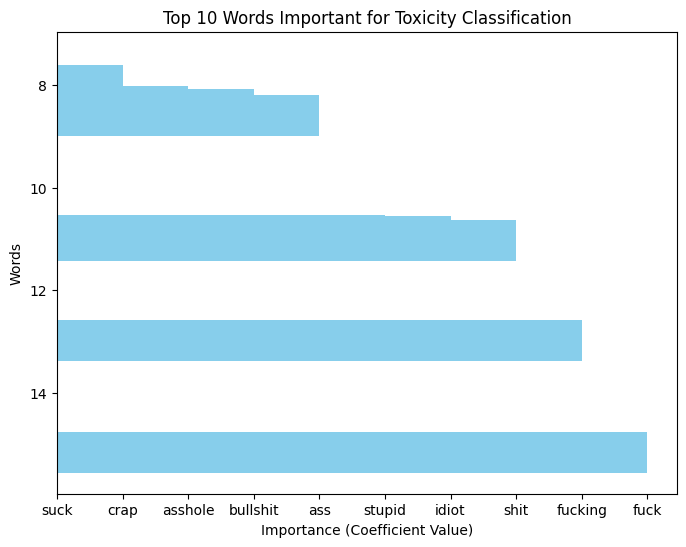

In [19]:
import matplotlib.pyplot as plt
import numpy as np

sorted_items = sorted(zip(clf.coef_[0], vectorizer.get_feature_names_out()))
top_words = sorted_items[-10:]

words, importance = zip(*top_words)

plt.figure(figsize=(8, 6))
plt.barh(words, importance, color='skyblue')
plt.xlabel('Importance (Coefficient Value)')
plt.ylabel('Words')
plt.title('Top 10 Words Important for Toxicity Classification')
plt.gca().invert_yaxis()
plt.show()

### Confusion Matrix

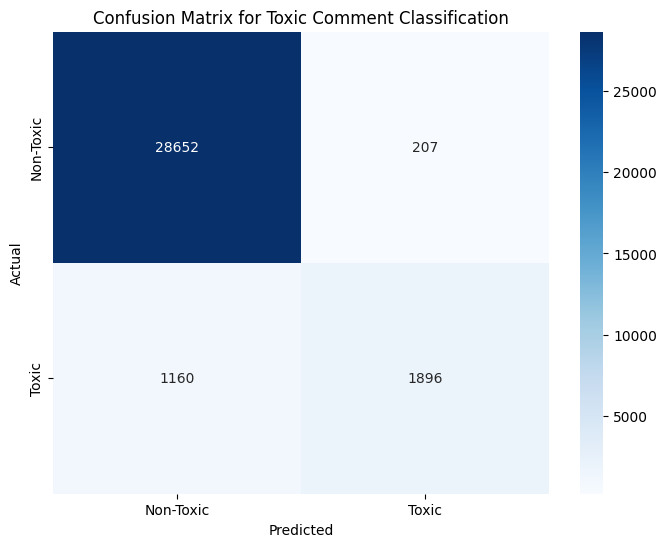

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = clf.predict(X_val)

cm = confusion_matrix(y_val['toxic'], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Toxic Comment Classification')
plt.show()

### Training Class Distributions

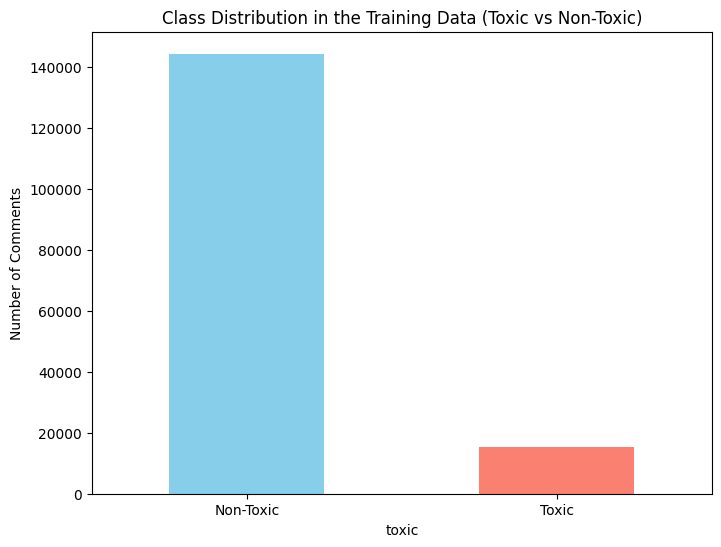

In [24]:
class_counts = train_df['toxic'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in the Training Data (Toxic vs Non-Toxic)')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'], rotation=0)
plt.ylabel('Number of Comments')
plt.show()